## 3. Dropout as Regularization

### Import necessary  libraries

We use GPUs for deep learning. If you want to try our code in CPU, remove all `.cuda()` in the notebook.

In [1]:
%env CUDA_VISIBLE_DEVICES=2
import numpy as np
import pandas as pd
import time
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

env: CUDA_VISIBLE_DEVICES=2


### Load MNIST Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0, 0, 0), (1, 1, 1))])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

### Dropout Implementation

We should multiply the dropout output by $\frac{1}{1-p}$ where $p$ is the dropout rate to compensate for the dropped neurons. We implemented a dropout layer below, it should have same functionality as `nn.Dropout` in Pytorch.

In [3]:
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0-p)
        else:
            self.multiplier_ = 0.0
    def forward(self, input):
        if not self.training:
            return input
        selected_ = torch.Tensor(input.shape).uniform_(0,1)>self.p
        #selected_num = torch.sum(selected_)
        #if selected_num > 0:
        #    multiplier_ = torch.numel(selected_)/selected_num
        #else:
        #    multiplier_ = 0
        if input.is_cuda:
            selected_ = Variable(selected_.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ = Variable(selected_.type(torch.FloatTensor), requires_grad=False)
        return torch.mul(selected_,input) * self.multiplier_

### Build the Network

We use the code below to build the network as described in the paper, including dropout, training (with mini-batch and SGD), and testing.

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("dropout0",MyDropout(p=droprates[0]))
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("tanh", nn.Tanh())
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden"+str(i+1), MyDropout(p=droprates[1]))
            self.model.add_module("hidden"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))
        #self.model.add_module("logsoftmax", nn.LogSoftmax(dim=1))
        
        
    def forward(self, x):
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x
    
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=100, max_epoch=10, \
                 lr=0.1, momentum=0):
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates)
        self.model.cuda()
        #self.criterion = nn.NLLLoss()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        print(self)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose or epoch + 1 == self.max_epoch:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        print('Finished Training.')
        return self
    
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)

The paper tried three networks. One with no dropout, one with dropout in hidden layers and one with dropout in both hidden layers and input. The training takes really long time. We recommend using GPU to reproduce our results.

You can set `verbose=True` to see loss and accuracy of each epoch.

In [5]:
hidden_layers = [800, 800]
mlp1 = [MLPClassifier(hidden_layers, droprates=[0, 0], max_epoch=1500), 
        MLPClassifier(hidden_layers, droprates=[0, 0.5], max_epoch=1500),
        MLPClassifier(hidden_layers, droprates=[0.2, 0.5], max_epoch=1500)]

In [6]:
%%time

print(mlp1[0].model)
mlp1[0].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0, 0]
Test error: 169; test accuracy: 0.9831
Finished Training.
CPU times: user 2h 7min 47s, sys: 3min 25s, total: 2h 11min 12s
Wall time: 2h 11min 8s


In [7]:
%%time

print(mlp1[1].model)
mlp1[1].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0, 0.5]
Test error: 149; test accuracy: 0.9851
Finished Training.
CPU times: user 2h 8min 3s, sys: 3min 24s, total: 2h 11min 27s
Wall time: 2h 11min 24s


In [8]:
%%time

print(mlp1[2].model)
mlp1[2].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0.2, 0.5]
Test error: 112; test accuracy: 0.9887
Finished Training.
CPU times: user 1h 59min 20s, sys: 3min 13s, total: 2h 2min 34s
Wall time: 2h 2min 29s


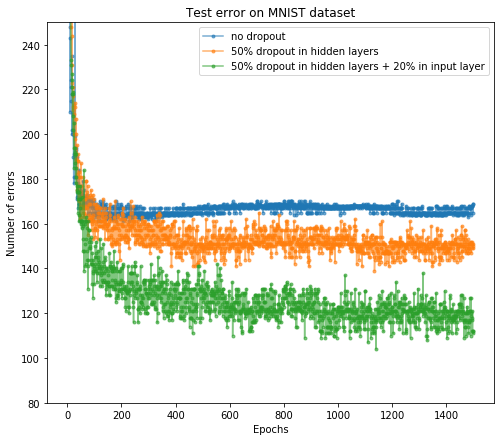

In [9]:
results = [(mlp.loss_, mlp.test_accuracy, mlp.test_error) for mlp in mlp1]
labels = ['no dropout', '50% dropout in hidden layers', '50% dropout in hidden layers + 20% in input layer']

plt.figure(figsize=(8, 7))
for i, r in enumerate(results):
    plt.plot(range(1, len(r[2])+1), r[2], '.-', label=labels[i], alpha=0.6);
plt.ylim([80, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors');
plt.title('Test error on MNIST dataset');

The result above is similar to what is described in the paper. As we can see, dropout works.

## 4. Dropout as Bayesian Approximation
It is shown that deep NNs with dropout applied before every weight layer are mathematically equivalent to approximate variational inference in the deep Gaussian process marginalised over its covariance function parameters (Yarin Gal et al). 

The related Gaussian process could be described as below:

$$F \vert X, W_1, b \sim N(0, K(X,X))$$
$$Y \vert F \sim N(F, \tau^{-1}I_N)$$
Introduing $W_1$, which is a matrix parameterizing the covariance function K:
$$ p(Y\vert X) = \int p(Y\vert F)p(F\vert W_1, b, X)p(W_1)p(b)$$
Introduing $W_2$, another matrix that get the integration rid of F:
$$ p(Y\vert X) = \int p(Y\vert X, W_1, W_2, b)p(W_1)p(W_2)p(b)$$
To perform variational inference in our approximate model we need to define a variational distribution $q(W_1, W_2, b) := q(W_1)q(W_2)q(b)$, where $q(W_1)$ and $q(W_2)$ are defined as a Gaussian mixture model with two components, factorized over dimensinality of $W_1$ and $W_2$. For example: 

$$q(W_1) = \prod_{q=1}^{Q}q(w_q) $$
$$ q(w_q) = p_1N(m_q, \sigma^2I_K) + (1-p_1)N(0,\sigma^2I_K)$$

with some probability p1 ∈ [0, 1], scalar σ > 0 and $m_q ∈ R^K $

In dropout model, the input was weighted by some weight matrix and then pass into some non-linear function, which is the same as what we did with the parameterizing matrix and covariance function. The output of the non-linear function would be the input of the next hidden layer. When we implement dropout, we actually created a binary vector to decide which hidden unit would be passed to the next layer, which is similar to what we did for the variational inference. With this setup, we update the parameters by minimizing some loss function we choose, just as minimizing KL divergence in Gaussian process approximation.


### 4.1. Dropout as Bayesian Approximation in Classification Task

In [1]:
import numpy as np
import pandas as pd
import time
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0, 0, 0), (1, 1, 1))])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
X_test, y_test = iter(testloader).next()
X_test = X_test.numpy()
X1 = np.array([rotate(X_test[9978].squeeze(), i, reshape=False) for i in range(60, 120, 5)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

In [3]:
def caloutdim(hin, kernel_size, stride=1, padding=0, dilation=1):
    return int(np.floor((hin+2*padding-dilation*(kernel_size-1)-1)/stride+1))

d = [28]
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
d

[28, 28, 14, 14, 7]

In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class LeNet(nn.Module):
    def __init__(self, droprate=0.5):
        super(LeNet, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(1, 20, kernel_size=5, padding=2))
        self.model.add_module('dropout1', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool1', nn.MaxPool2d(2, stride=2))
        self.model.add_module('conv2', nn.Conv2d(20, 50, kernel_size=5, padding=2))
        self.model.add_module('dropout2', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool2', nn.MaxPool2d(2, stride=2))
        self.model.add_module('flatten', Flatten())
        self.model.add_module('dense3', nn.Linear(50*7*7, 500))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout3', nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(500, 10))
        
    def forward(self, x):
        return self.model(x)
    
class LeNetClassifier:
    def __init__(self, droprate=0.5, batch_size=64, max_epoch=300, lr=0.01):
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = LeNet(droprate)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_ = []
        
    def fit(self, trainset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        print(self.model)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose and ((epoch+1) % (self.max_epoch//10) == 0 or epoch == 0):
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
        return self
    
def predict_class(model, X):
    model = model.eval()
    outputs = model(Variable(X.cuda()))
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.cpu().numpy()

def score(model, X, y):
    return np.mean(predict_class(model, X) == y)

def predict(model, X, T=1000):
    standard_pred = predict_class(model, X)
    y1 = []
    y2 = []
    for _ in range(T):
        _y1 = model(Variable(X.cuda())).cpu()
        _y2 = F.softmax(_y1, dim=1)
        y1.append(_y1.data.numpy())
        y2.append(_y2.data.numpy())
    return standard_pred, np.array(y1), np.array(y2)

In [5]:
%%time

lenet1 = LeNetClassifier().fit(trainset)

LeNet(
  (model): Sequential(
    (conv1): Conv2d (1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout1): Dropout2d(p=0.5)
    (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (conv2): Conv2d (20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout2): Dropout2d(p=0.5)
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (flatten): Flatten(
    )
    (dense3): Linear(in_features=2450, out_features=500)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.5)
    (final): Linear(in_features=500, out_features=10)
  )
)
Epoch 1 loss: 1.1765512890144707
Epoch 30 loss: 0.062384041379700335
Epoch 60 loss: 0.03598022286190407
Epoch 90 loss: 0.025289509679748814
Epoch 120 loss: 0.018099108675141324
Epoch 150 loss: 0.015613067172356505
Epoch 180 loss: 0.012091124243637138
Epoch 210 loss: 0.010123401999410028
Epoch 240 loss: 0.009247995932886341
Epoch 270 loss: 0.008735214461332191
Epoch 300 loss: 0.00784705897

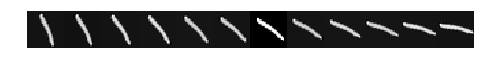

In [6]:
plt.figure(figsize=(8, 1))

gs = gridspec.GridSpec(1, 12)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

In [7]:
print('Test score: {}'.format(score(lenet1.model, torch.from_numpy(X_test), y_test)))

Test score: 0.9925


In [8]:
y1_pred, y1_si, y1_so = predict(lenet1.model, torch.from_numpy(X1))
print(y1_pred)

[1 1 1 1 1 2 7 7 7 7 7 7]


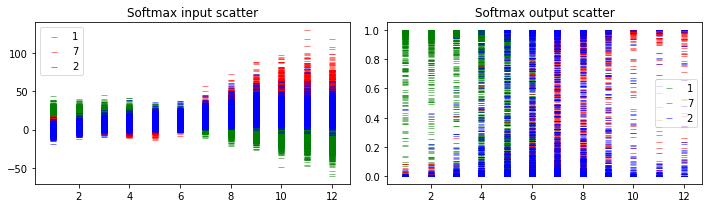

In [11]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.5, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.5, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 2].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.5, label='2');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.5, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.5, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 2].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.5, label='2');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();